# Plots of Base Case Fluxes

In [4]:
import arrow
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.colorbar as mcb
from matplotlib.patches import Ellipse
from matplotlib import gridspec
import netCDF4 as nc
import numpy as np
import os
import pandas as pd

from salishsea_tools import viz_tools

%matplotlib inline

results_dir = '/ocean/sallen/allen/research/MEOPAR/Ariane/mixing_paper/'
spec_dir = 'StatsFiles/'
other_nan = ['********************']

## Read the Results

In [115]:
rawstats = ['sn', 's0max', 's0min', 's0x', 's0x2', 's1max', 's1min', 's1x', 's1x2']

def _make_datasets(start_f, ndays, results_dir, subdir, spec_dir):
    stat = {}
    Arriving = pd.DataFrame(data=None, index=None, 
                           columns=['day', 'longitude-mean', 'longitude-stderr', 'depth-mean', 'depth-stderr',
                                   'salinity-mean', 'salinity-stderr', 'age-mean', 'age-stderr', 'flux', 
                                    'flux-stderr'],
                           dtype=None, copy=False)
    Leaving = pd.DataFrame(data=None, index=None, 
                           columns=['day', 'latitude-mean', 'latitude-stderr', 'depth-mean', 'depth-stderr',
                                   'salinity-mean', 'salinity-stderr'],
                           dtype=None, copy=False)
    thedays = []
    mean = np.zeros((5))
    stdev = np.zeros((4))

    line = 0
    for nday in range(start_f, start_f+ndays):
        for stattype in rawstats:
            stat[stattype] = pd.read_csv(os.path.join(results_dir, subdir, spec_dir,
                                        stattype+'.day'+str(nday)), 
                                        index_col=0, na_values=other_nan)
            stat[stattype].index = [x.strip() for x in stat[stattype].index]
        for i, parameter in enumerate(['depth', 'longitude', 'sal', 'age']):
            themean = stat['s1x'][parameter]/stat['sn']['sn']
            thestdev = np.sqrt(np.abs((stat['s1x2'][parameter] - 
                                     stat['s1x'][parameter]**2 / stat['sn']['sn'])
                                    / (stat['sn']['sn']-1)))
            mean[i] = getattr(themean, region)
            stdev[i] = getattr(thestdev, region)
        mean[4] = getattr(stat['sn']['flux'], region)
        nopart = getattr(stat['sn']['number'], 'total')
        vicpart = getattr(stat['sn']['number'], region)
        prob = vicpart/nopart
        stderr = np.sqrt(prob*(1-prob)/nopart) /prob * mean[4]
        err2dev = 1./np.sqrt(vicpart)
        Arriving.loc[line] = [nday, mean[1], stdev[1]*err2dev, mean[0], stdev[0]*err2dev, 
                                 mean[2], stdev[2]*err2dev, mean[3], stdev[3]*err2dev, mean[4], stderr]
        for i, parameter in enumerate(['depth', 'latitude', 'sal']):
            themean = stat['s0x'][parameter]/stat['sn']['sn']
            thestdev = np.sqrt(np.abs((stat['s0x2'][parameter] - 
                                     stat['s0x'][parameter]**2 / stat['sn']['sn'])
                                    / (stat['sn']['sn']-1)))
            mean[i] = getattr(themean, region)
            stdev[i] = getattr(thestdev, region)
        Leaving.loc[line] = [nday, mean[1], stdev[1]*err2dev, mean[0], stdev[0]*err2dev, mean[2], stdev[2]*err2dev]
        line = line + 1
    Arriving = Arriving.set_index('day')
    Leaving = Leaving.set_index('day')
    return Leaving, Arriving

In [118]:
def _make_plot(ax, Leaving, Arriving, textstring, run):
    print(textstring)
    ax[0,0].plot(Leaving.index, Leaving['salinity-mean'], 's-', label=run)
    ax[0,0].plot(Leaving.index, Leaving['salinity-mean']+Leaving['salinity-stderr'])
    ax[0,0].plot(Leaving.index, Leaving['salinity-mean']-Leaving['salinity-stderr'])
    ax[0,0].set_title('Salinity at Boundary Pass')
    ax[0,0].set_ylim((23, 34))
    ax[0,0].legend(loc='lower right')
    ax[0,0].set_ylabel('Salinity [g kg$^{-1}$]')

    ax[0,1].plot(Arriving.index, Arriving['salinity-mean'], 'o-', label=run)
    ax[0,1].plot(Arriving.index, Arriving['salinity-mean']+Arriving['salinity-stderr'])
    ax[0,1].plot(Arriving.index, Arriving['salinity-mean']-Arriving['salinity-stderr'])
    ax[0,1].set_ylim((23, 34))
    ax[0,1].set_title('Salinity at Victoria Sill')
    ax[0,1].legend(loc='lower right')

    ax[1,0].plot(Leaving.index, Leaving['depth-mean'], 's-')
    ax[1,0].plot(Leaving.index, Leaving['depth-mean']+Leaving['depth-stderr'])
    ax[1,0].plot(Leaving.index, Leaving['depth-mean']-Leaving['depth-stderr'])
    ax[1,0].set_title('Depth at Boundary Pass')
    ax[1,0].set_ylim((150, 0))
    ax[1,0].set_ylabel('Depth [m]')

    ax[1,1].plot(Arriving.index, Arriving['depth-mean'], 'o-')
    ax[1,1].plot(Arriving.index, Arriving['depth-mean']+Arriving['depth-stderr'])
    ax[1,1].plot(Arriving.index, Arriving['depth-mean']-Arriving['depth-stderr'])
    ax[1,1].set_ylim((150, 0))
    ax[1,1].set_title('Depth at Victoria Sill')

    ax[2,0].plot(Arriving.index, Arriving['flux'], 'o-', label=run)
    ax[2,0].plot(Arriving.index, Arriving['flux']+Arriving['flux-stderr'])
    ax[2,0].plot(Arriving.index, Arriving['flux']-Arriving['flux-stderr'])
    ax[2,0].set_title('Flux between Boundary Pass and Victoria Sill')
    ax[2,0].set_ylim((0,30000))
    ax[2,0].set_ylabel('Flux [m$^3$ s$^{-1}$]')
    ax[2,0].legend()

    ax[2,1].plot(Arriving.index, Arriving['age-mean']*40, 'o-', label=run)
    ax[2,1].plot(Arriving.index, (Arriving['age-mean']+Arriving['age-stderr'])*40)
    ax[2,1].plot(Arriving.index, (Arriving['age-mean']-Arriving['age-stderr'])*40)
    ax[2,1].set_title('Transit Time between Boundary Pass and Victoria Sill')
    ax[2,1].set_ylim((0,16))
    ax[2,1].set_ylabel('Time [days]')

Forward Fluxes: from Boundary Pass to Victoria Sill
base_jul 7569.148687999999 95.7326148245
   Leaving Depth 18.616095465797795 0.394633249402
   Arriving Salinity 30.96768823322392 0.00875899829869
Forward Fluxes: from Boundary Pass to Victoria Sill
holl_jul 8470.930919999999 100.666879759
   Leaving Depth 21.47320903592098 0.452505985636
   Arriving Salinity 30.439223222019265 0.00980514814487
Forward Fluxes: from Boundary Pass to Victoria Sill
kw 7250.937263999999 93.2315233104
   Leaving Depth 17.08945137280993 0.381213667475
   Arriving Salinity 31.002209746011843 0.00913860908008
Forward Fluxes: from Boundary Pass to Victoria Sill
horizontal 7612.390636 96.3273411011
   Leaving Depth 18.40115401628467 0.400054097786
   Arriving Salinity 31.00561672092498 0.00865857294637


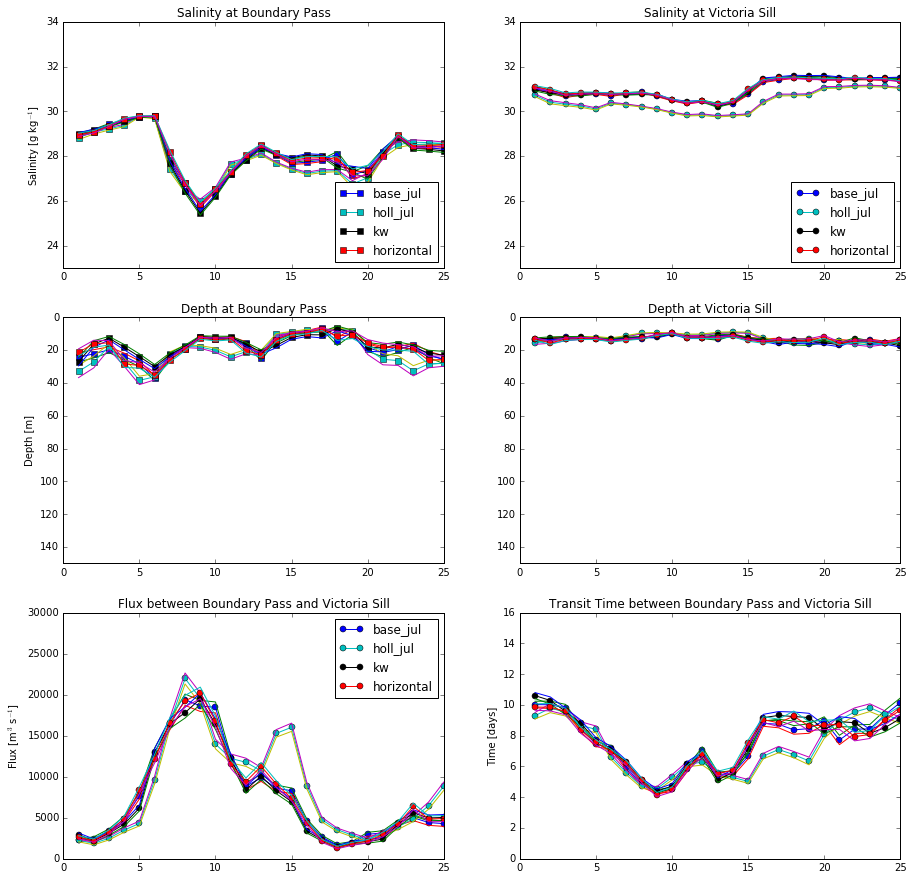

In [128]:
SouthFluxes = {}
ndays = 25
start_f = 1
fig, ax = plt.subplots(3,2, figsize=(15,15))
region = 'VictoriaSill'

for run in ['base_jul', 'holl_jul', 'kw', 'horizontal']:
    subdir = run + '/FluxesSouth'
    SouthFluxes['Leaving'], SouthFluxes['Arriving'] = _make_datasets(start_f, ndays, results_dir, subdir, spec_dir)
    _make_plot(ax, SouthFluxes['Leaving'], SouthFluxes['Arriving'],
          'Forward Fluxes: from Boundary Pass to Victoria Sill', run)
    print (run, np.mean(SouthFluxes['Arriving']['flux']), np.mean(SouthFluxes['Arriving']['flux-stderr'])/np.sqrt(15))
    print ('   Leaving Depth', np.mean(SouthFluxes['Leaving']['depth-mean']), 
           np.mean(SouthFluxes['Leaving']['depth-stderr'])/np.sqrt(15))
    print ('   Arriving Salinity', np.mean(SouthFluxes['Arriving']['salinity-mean']), 
           np.mean(SouthFluxes['Arriving']['salinity-stderr'])/np.sqrt(15))

Backward Fluxes: to Boundary Pass from Victoria Sill
base_jul 15199.831620000003 163.705297814
   Arriving Depth 115.00286795058382 0.388055050078
   Leaving Salinity 32.68944257996668 0.00453571710888
   Arriving Salinity 30.47465878118606 0.00208795381775
Backward Fluxes: to Boundary Pass from Victoria Sill
holl_jul 17346.707455999996 175.874242251
   Arriving Depth 118.47483064577766 0.333555856533
   Leaving Salinity 32.94992274017028 0.00434767793093
   Arriving Salinity 31.099069821450826 0.00275856451867
Backward Fluxes: to Boundary Pass from Victoria Sill
kw 15407.932684000005 164.01254132
   Arriving Depth 112.91718260471065 0.399558089011
   Leaving Salinity 32.598125466812306 0.00466365846609
   Arriving Salinity 30.358606957347728 0.00182896786857
Backward Fluxes: to Boundary Pass from Victoria Sill
horizontal 15334.937084 164.54972174
   Arriving Depth 115.21331401535049 0.391821344684
   Leaving Salinity 32.66850821082794 0.00441229880795
   Arriving Salinity 30.447634418

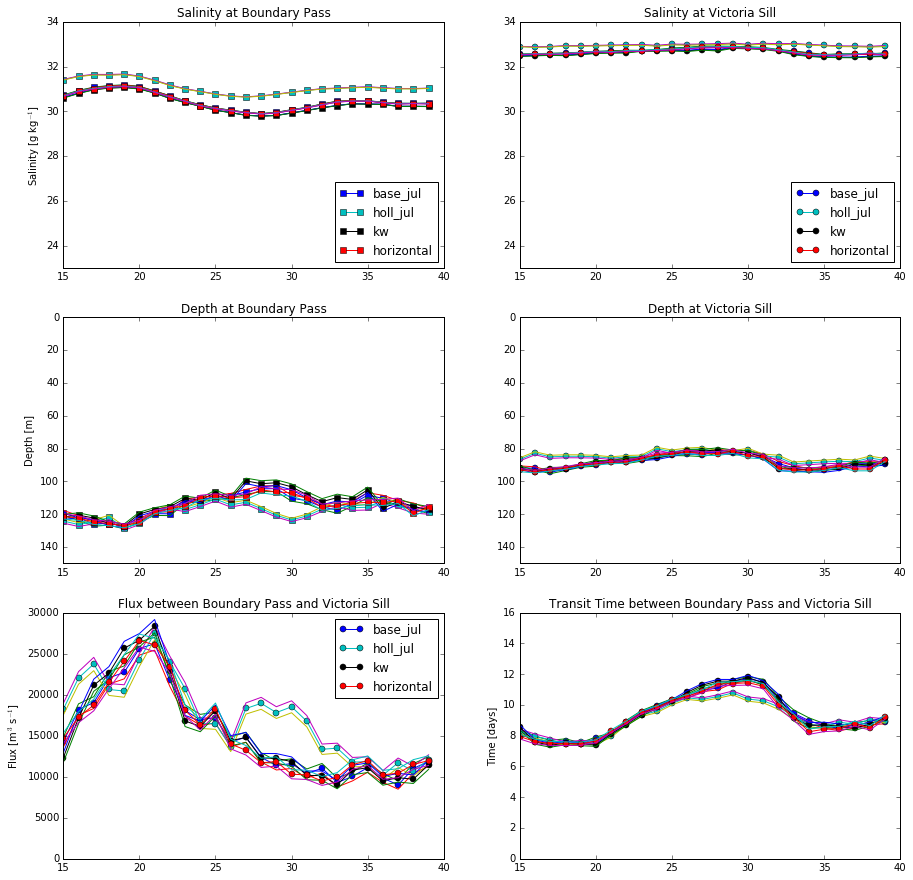

In [129]:
BackSouthFluxes = {}
ndays = 25
start_b = 15
fig, ax = plt.subplots(3,2, figsize=(15,15))
region = 'VictoriaSill'

for run in ['base_jul', 'holl_jul', 'kw', 'horizontal']:
    subdir = run + '/BackFluxesSouth'
    BackSouthFluxes['Leaving'], BackSouthFluxes['Arriving'] = _make_datasets(start_b, ndays, results_dir, subdir, spec_dir)
    _make_plot(ax, BackSouthFluxes['Leaving'], BackSouthFluxes['Arriving'],
          'Backward Fluxes: to Boundary Pass from Victoria Sill', run)
    print (run, np.mean(BackSouthFluxes['Arriving']['flux']), 
           np.mean(BackSouthFluxes['Arriving']['flux-stderr'])/np.sqrt(15))
    print ('   Arriving Depth', np.mean(BackSouthFluxes['Leaving']['depth-mean']), 
           np.mean(BackSouthFluxes['Leaving']['depth-stderr'])/np.sqrt(15))
    print ('   Leaving Salinity', np.mean(BackSouthFluxes['Arriving']['salinity-mean']), 
           np.mean(BackSouthFluxes['Arriving']['salinity-stderr'])/np.sqrt(15))
    print ('   Arriving Salinity', np.mean(BackSouthFluxes['Leaving']['salinity-mean']), 
           np.mean(BackSouthFluxes['Leaving']['salinity-stderr'])/np.sqrt(15))